# Entropy

We estimate the joint probability function of the dataset and estimate the entropy of various subsets. Additionally we estimate the conditional probability of game success by looking at the various statistics at our disposal. For our purpose we use the package ks (https://cran.r-project.org/web/packages/ks/index.html), which contains density function estimators.

In [180]:
DATACAPTIONVEC <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE")

In the first step we read the input data as generated by the python class dataMiner.py.

In [181]:
nhlDataSum=data.frame()
nhlDataDelta=data.frame()
SeasonVector=c(2010,2011,2012,2014,2015,2016)
NumberOfSeasons=length(SeasonVector)
for(season in SeasonVector)
{
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_sum.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataSum<-rbind(nhlDataSum,nhlDataS)
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_delta.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataDelta<-rbind(nhlDataDelta,nhlDataS)
}
colnames(nhlDataSum) <- DATACAPTIONVEC
colnames(nhlDataDelta) <- DATACAPTIONVEC

The input data consists of data with postfix Delta and Sum, with Sum data defined as $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{D}^{d}$ and $X_{\Sigma}=X_{h}+X_{a}$ with $X_{h,a} \in \mathbb{D}^{d}$ ($\mathbb{D}$ a mixture of binary and natural numbers), d dimensional home and away team statistics vectors. In our case every datasample has 16 entries,with 10 numerical attributes per dataset, giving d=10. The first 6 attributes of each dataset like season, game id and teams who played contain supplementery information and are important only in the preprocessing process. We may write our dataset as "set" $X_{\Delta,Sum} = F ( x_{won},x_{score},x_{shots},x_{faceoff},x_{takeaway},x_{giveaway},x_{pim},x_{hits},x_{ppg},x_{attendance} )$ with F a function of the datasets for home and away teams, as described above. $x_{won}$ takes binary values $x_{won} \in [0,1]$, 0 for loss and 1 for game won. The other attributes take integer values.

In [182]:
teams <- nhlDataDelta$TEAM1
LISTOFTEAMS=unique(teams)
print("we have the following teams")
print(LISTOFTEAMS)

[1] "we have the following teams"
 [1] BOS       TOR       COL       CGY       CAR       PIT       CHI      
 [8] DET       BUF       NJ        NYI       NYR       WSH       ATLANTA  
[15] FLA       CBJ       DAL       STL       EDM       ANA       LA       
[22] VAN       PHI       MIN       TB        NSH       SJ        PHO      
[29] CANADIENS OTT       WPG       MTL       ARI      
33 Levels: ANA ATLANTA BOS BUF CANADIENS CAR CBJ CGY CHI COL DAL DET ... ARI


In the first step we coarse grain the data. One reason for this is to make the computational feat of multidimensional probability function estimation more feasible. The second is that the phase space volume is so vast and data scattered so sparsly, that an agglomeration into more coarse categories may not do harm in reducing the information content. The coarse graining is determined by one parameter only, the number of parts in which every data column is subdivided.

In [183]:
coarseGraining <- function(dataMatrix,parts)
{
  #coarse graining of input data.matrix
  grainedMatrix = matrix(nrow=nrow(dataMatrix),ncol=ncol(dataMatrix))
  centroidMatrix = matrix(nrow=parts,ncol=ncol(dataMatrix))
  for(j in 1:ncol(dataMatrix))
  {
    colVals=dataMatrix[,j]
    coarsedGrainedColData=c()
    maxV=max(colVals)
    minV=min(colVals)
    delta=(maxV-minV)/parts
    centroidV=minV+0:(parts-1)*delta+delta/2
    for(jj in 1:length(colVals))
      {
        #get the index of nearest element of column Values in centroidVector
      actualVal<-colVals[jj]
      coarsedGrainedColData[jj]=centroidV[which.min(abs(centroidV-colVals[jj]))]
    }
    #now add data to matrix
    grainedMatrix[,j] <- coarsedGrainedColData
    centroidMatrix[,j] <- centroidV
  }#next matrix column
  
    #return the coarse grained data matrix and centroid vectors
  return(list("coarseGrainedMatrix"=grainedMatrix,"centroidVectors"=centroidMatrix))
}

Before doing the actual coarse graining we cut the data so that it fits into predefined quantiles.

In [184]:
cutDataMatrix <- function(dataMatrix,boundCriterionScalar)
{
  #cut values which are out of the boundCriterionVector, which has
  #as many columns as the dataMatrix and scale the output matrix
 
  
  if(boundCriterionScalar < 0.5 || boundCriterionScalar>0.9)
  {
    boundCriterionScalar=0.9
  }
  
  #we record all the data rows where extreme values occur and do not return them
  rowsToKeep=c()
  
  for(j in 1:ncol(dataMatrix))
  {
    colVals=dataMatrix[,j]
    #determine the value in which boundCriterionScalar percent of data is contained - mirror negative data
    bounds=quantile(abs(colVals),probs=c(boundCriterionScalar))
    rowsToKeep <- which(abs(colVals)<bounds)
  }
  #now assemble the output matrix
  returnMatrix <- dataMatrix[rowsToKeep,]
  return(returnMatrix)
  
}

We define a small helper function to extract data from the dataframe and put it into a manageable data matrix.

In [185]:
fetchDataColumnsAsMatrix <- function(dataFrame)
{
#input dataframe
#output matrix of certain columns of dataframe, fixed in function

return(as.matrix(cbind(dataFrame$SHOTS,dataFrame$FACEOFF,dataFrame$HITS,dataFrame$TAKEAWAY,dataFrame$GIVEAWAY,dataFrame$PIM,dataFrame$PPG)))

}

In [186]:
nhlDataMatrix=fetchDataColumnsAsMatrix(nhlDataDelta)
print(paste("We analyze",nrow(nhlDataMatrix),"games characterized by",ncol(nhlDataMatrix),"attributes."))

[1] "We analyze 6603 games characterized by 7 attributes."


In [187]:
#now cut the data in the region where 75% of its values lie
CUTDATAVAL = 0.9
cutNhlDataMatrix <- cutDataMatrix(nhlDataMatrix,CUTDATAVAL)
returnVal=coarseGraining(cutNhlDataMatrix,6)
McoarseGrained=returnVal$coarseGrainedMatrix
centroidVectors=returnVal$centroidVectors
print(paste("The coarse grained matrix has",nrow(McoarseGrained),"rows and the centroid Matrix",nrow(centroidVectors)))
print(paste("The coarse grained matrix has",ncol(McoarseGrained),"columns and the centroid Matrix",ncol(centroidVectors)))

[1] "The coarse grained matrix has 5702 rows and the centroid Matrix 6"
[1] "The coarse grained matrix has 7 columns and the centroid Matrix 7"


Now we write a function to coarse grain data according to a precomputed coarse graining matrix, consisting of multiple centroid vectors. 

In [188]:
coarseGrainingGrainMatrix <- function(matrixToGrain,centroidVectors)
{
  #categorize input data in matrix grainMatrix according to centroids set in centroidVectors
  #return matrix with values from centroidVectors
  if(is.vector(matrixToGrain))
  {
    matrixToGrain <- as.matrix(matrixToGrain)
    if(ncol(matrixToGrain)<nrow(matrixToGrain))
      {
      matrixToGrain <- t(matrixToGrain)
      }
    #grainedMatrix=as.matrix(matrixToGrain)
  #  grainedMatrix = matrix(nrow=1,ncol=length(matrixToGrain))
  }
  grainedMatrix = matrix(nrow=nrow(matrixToGrain),ncol=ncol(matrixToGrain))

    for(j in 1:ncol(matrixToGrain))
  { 
    centroidV=centroidVectors[,j]
    colVals=matrixToGrain[,j]
    coarsedGrainedColData=c()
    for(jj in 1:length(colVals))
    {
      #get the index of nearest element of column Values in centroidVector
      actualVal<-colVals[jj]
      coarsedGrainedColData[jj] <- centroidV[which.min(abs(centroidV-actualVal))]
    } 
    #now add data to matrix
    grainedMatrix[,j] <- coarsedGrainedColData
  }
  return(grainedMatrix)
}

A small helper function will compute the volumes of the bins in the data bin matrix for us.

In [189]:
volumeOfGrainedMatrixBin <- function(centroidVectors)
{
  #return the volume of one multidimensional cell point in the grained matrix
  dV <-1
  nrows <- nrow(centroidVectors)
  for(j in 1:ncol(centroidVectors))
  {
  dV <- dV*((max(centroidVectors[,j])-min(centroidVectors[,j]))/nrows)
  }
  return(dV)
}

In the next step we define a multivariate probability function (PDF) by counting the occurences of a datasets within the coarse data bins defined by centroid vectors. This number is then divided by the volume of the data bin, as well as the overall number of samples used to evaluate the probability density. The following function "computeMultivariateP" takes a vector and counts the occurences of its values in the grained input Matrix, which defines the PDF.

In [190]:
computeMultivariateP <- function(grainedMatrix,centroidMatrix,valueVector)
{
#simple function to compute the multivariate PDF 
#:param grainedMatrix: coarse grained datamatrix of input values with D categories and N samples
#:param centroidMatrix: matrix of coarse grain bin values
#:param valueVector: D dimensional input vector for which the probability is computed
#:return probability to find valueVector values in grainedMatrix data matrix

#using coarse grained matrix
#total number of categories is D
D=ncol(grainedMatrix)
#total number of datasets is N
N=nrow(grainedMatrix)
#noParts=nrow(centroidMatrix)

#Pmatrix has noParts**D elements
#probability of value value - computed by counting and normalizing
foundElementsVector=c()
#start with all the indices - then reduce by intersecting with index values found!
intersectionsFound=1:N
dVolume <- volumeOfGrainedMatrixBin(centroidMatrix)
for(j in 1:D)
{
  #return index for matched elements
  foundElementsVector=which(grainedMatrix[,j]==valueVector[j])
  #compute the intersection of the two vectors
  intersectionsFound<-intersect(intersectionsFound,foundElementsVector)
}
#now calculate the number of found values
n=length(intersectionsFound)
#now divide by the sum of all elements to get probability estimate
P=n/N/dVolume
return(P)
}

In our case we estimate the PDF from the $X_{\Delta}$ data. Then we will estimate the entropy of the various teams season games to see how far their game is away from uniformity in the sense the PDF defines this notion. (Or from thermal equilibrium as one puts the most probable, final state in a system in contact with a thermal bath in thermodynamics.) To this end we define an entropy function, which adds up the entropy per samples defined by Shannon as: $E=\sum_{k} P_{k} ln(P_{k})$, where a summation over all states k is implied, and $P_{k}$ is the probability of the state in the full state space. The following function getEntropy does the summation and returns a number indicating the entropy value of the subsystem (team stats) in the overall system whole $X_{\Delta}$ dataset.

In [191]:
getEntropy <- function(grainedMatrix,centroidMatrix,valueMatrix)
{
  #compute the entropy given a coarse grained matrix defining the PDF and the dataset 
  #to compute the entropy for
  Psum=0
  Pmax=0
  Entropy=0
    
  dVolume <- volumeOfGrainedMatrixBin(centroidMatrix)
  
  if(is.vector(valueMatrix))
  {
    valueMatrix <- as.matrix(valueMatrix)
  }
  
  noGames=0
  for(i in 1:nrow(valueMatrix))
  {
    valueVector <- valueMatrix[i,]
    P<-computeMultivariateP(grainedMatrix,centroidMatrix,valueVector)
    #compute only for valid values
    if(P>0)
        {
        P<-P*dVolume
        Entropy=Entropy-P*log(P)
        Pmax=max(Pmax,P)
        noGames=noGames+1
        }
  }

  return(Entropy/noGames)
  
}

This function is called for every team and the entropy number divided by the number of samples to get the entropy per game. (Entropy is summed, an extensive quantity, scaling with volume, or game number in this case) The data we use is the home game data of every team, one could do the same for games played by the away team. 

In [192]:
EvaluesV=c()
for(team in LISTOFTEAMS)
{
    matchDH<-subset(nhlDataDelta,nhlDataDelta$TEAM1==team)
    #now get the matrix 
    matchDataMatrix <- fetchDataColumnsAsMatrix(matchDH)
    #grain the matrix
    grainedMatchDataMatrix<-coarseGrainingGrainMatrix( matchDataMatrix ,centroidVectors)
    #compute the entropy
    EntropyPerGame<-getEntropy(McoarseGrained,centroidVectors,grainedMatchDataMatrix)
    #compute average entropy per game
    #Entropy<-Entropy/nrow(matchDataNYIMatrix)
    EvaluesV <- c(EvaluesV,EntropyPerGame)
}

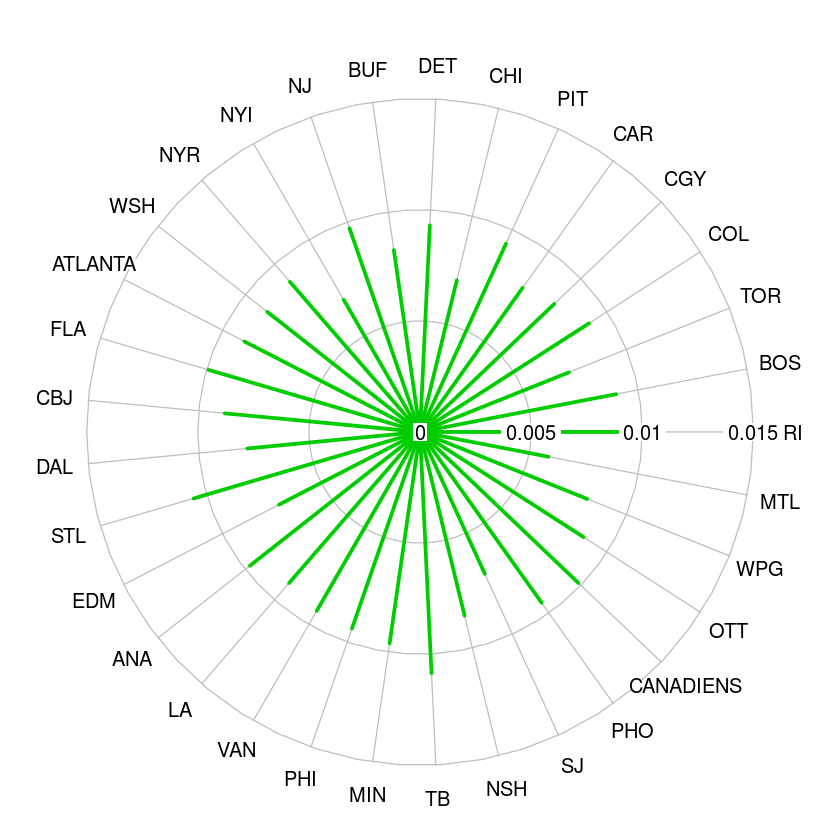

In [196]:
dfToPlot = data.frame(LISTOFTEAMS,EvaluesV)
library(plotrix)
dataV=dfToPlot$EvaluesV
labelsV=dfToPlot$LISTOFTEAMS
noTeams=length(dfToPlot$LISTOFTEAMS)
delta=360./noTeams
labelPos=1:noTeams*delta
polar.plot(dataV,lwd=3,radial.lim=c(0,0.015),line.col=3,polar.pos=labelPos,labelsV,label.pos=labelPos,start=0,clockwise=FALSE,rp.type="r")

The plot shows that the game statistics of the Tampa Bay Lightning (TB) and St. Louis Blues (STL) deviate more strongly from the overall statistics of the league, whereas San Jose (SJ) game statistics shows lower values of entropy - game statis which are more conformant with the overall distribution of game statistics.